In [1]:
# 本节用到的pytorch包，框架名是pytorch，包名是torch
%reload_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # useful stateless functions
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

In [2]:
USE_GPU = False
dtype = torch.float32 # 数据类型全部使用float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cpu


In [3]:
# 使用shell脚本下载CIFAR10数据文件，有160多MB，下载时间跟网络状况有关
# 如有warning可执行：sudo apt install python3-pickleshare
# windows下不支持shell脚本运行，可参照get_datasets.sh中的命令手动下载数据到指定目录并解压
%cd src/dataset/
!bash get_datasets.sh
%cd ../../

/home/wangfiox/ai-hitsz/lab2/src/dataset
/home/wangfiox/ai-hitsz/lab2


In [4]:
# Load the raw CIFAR-10 data.
from src.util import load_CIFAR10,download_CIFAR10

cifar10_root = 'src/dataset/'
cifar10_dir = cifar10_root + 'cifar-10-batches-py'
# download_CIFAR10(cifar10_root)

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train # 析构函数
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


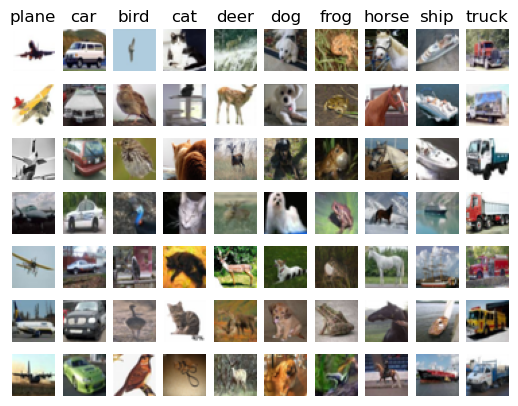

In [5]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
import matplotlib.pyplot as plt
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [6]:
NUM_TRAIN = 49000

# The torchvision.transforms package provides tools for preprocessing data
# and for performing data augmentation; here we set up a transform to
# preprocess the data by subtracting the mean RGB value and dividing by the
# standard deviation of each RGB value; we've hardcoded the mean and std.
transform = T.Compose([T.ToTensor(), T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]) # 归一化处理 (策略模式)

# We set up a Dataset object for each split (train / val / test); Datasets load
# training examples one at a time, so we wrap each Dataset in a DataLoader which
# iterates through the Dataset and forms minibatches. We divide the CIFAR-10
# training set into train and val sets by passing a Sampler object to the
# DataLoader telling how it should sample from the underlying Dataset.
cifar10_train = dset.CIFAR10("./src/dataset", train=True, download=True, transform=transform) # 加载训练集, 指定下载路径. 策略模式, 依赖注入
loader_train = DataLoader(cifar10_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))) # 迭代器模式

cifar10_val = dset.CIFAR10("./src/dataset", train=True, download=True, transform=transform) # 验证集
loader_val = DataLoader(cifar10_val, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)),)

cifar10_test = dset.CIFAR10("./src/dataset", train=False, download=True, transform=transform) # 测试集
loader_test = DataLoader(cifar10_test, batch_size=64)

In [7]:
def check_accuracy(loader, model):
    if loader.dataset.train:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')   
    num_correct = 0
    num_samples = 0
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct, num_samples, 100 * acc))

In [8]:
def train_model(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.
    
    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for
    
    Returns: Nothing, but prints model accuracies during training.
    """
    print_every = 200
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        print("Epochs :", e)
        for t, (x, y) in enumerate(loader_train): # t: 当前批次的索引; x: 输入的图像, y: 标签
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y) # 交叉熵作为损失函数(分类任务中常见)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            if t % print_every == 0:
                print('Iteration %d, loss = %.4f' % (t, loss.item()))
                check_accuracy(loader_val, model)
                print()

In [9]:
learning_rate = 1e-2

In [10]:
def flatten(x):
    N = x.shape[0]  # read in N, C, H, W
    return x.view(N, -1)  # "flatten" the C * H * W values into a single vector per image. 一张图片，其实是3维的向量, RGB通道 x 高度 x 宽度

In [11]:
# We need to wrap `flatten` function in a module in order to stack it
# in nn.Sequential
class Flatten(nn.Module):
    def forward(self, x):
        return flatten(x)

In [12]:
model = nn.Sequential(
    nn.Conv2d(in_channels=3, out_channels=48, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.Conv2d(in_channels=48, out_channels=96, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),
    nn.Conv2d(in_channels=96, out_channels=192, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.Conv2d(in_channels=192, out_channels=256, kernel_size=(3,3), padding=(1,1)),
    nn.ReLU(),
    nn.MaxPool2d(2, 2),
    nn.Dropout(0.25),
    Flatten(),
    nn.Linear(in_features=8*8*256, out_features=512),
    nn.ReLU(),
    nn.Linear(in_features=512, out_features=64),
    nn.ReLU(),
    nn.Dropout(0.25),
    nn.Linear(in_features=64, out_features=10),
)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, nesterov=True)

train_model(model, optimizer, 10)

Epochs : 0
Iteration 0, loss = 2.3033
Checking accuracy on validation set
Got 87 / 1000 correct (8.70)

Iteration 200, loss = 2.0141
Checking accuracy on validation set
Got 350 / 1000 correct (35.00)

Iteration 400, loss = 1.4999
Checking accuracy on validation set
Got 451 / 1000 correct (45.10)

Iteration 600, loss = 1.5226
Checking accuracy on validation set
Got 495 / 1000 correct (49.50)

Epochs : 1
Iteration 0, loss = 1.4776
Checking accuracy on validation set
Got 524 / 1000 correct (52.40)

Iteration 200, loss = 0.9610
Checking accuracy on validation set
Got 599 / 1000 correct (59.90)

Iteration 400, loss = 1.0116
Checking accuracy on validation set
Got 621 / 1000 correct (62.10)

Iteration 600, loss = 1.2519
Checking accuracy on validation set
Got 622 / 1000 correct (62.20)

Epochs : 2
Iteration 0, loss = 1.1291
Checking accuracy on validation set
Got 678 / 1000 correct (67.80)

Iteration 200, loss = 0.7803
Checking accuracy on validation set
Got 709 / 1000 correct (70.90)

Itera

In [13]:
best_model = model
check_accuracy(loader_test, best_model)

Checking accuracy on test set


Got 7964 / 10000 correct (79.64)
